# Solving Helmholtz equation with PINNs

In [1]:
from jaxdf.discretization import Continuous
from jaxdf.geometry import Domain

from matplotlib import pyplot as plt
from jax import numpy as jnp
import jax
from jax.example_libraries import stax
from jax import random

seed = random.PRNGKey(42)

In [2]:
def show_field(u):
    u = u.on_grid
    maxval = jnp.amax(jnp.abs(u)) 
    plt.figure(figsize=(8,6))
    plt.imshow(u, cmap="RdBu", extent=[0,1,-1,1], vmin=-maxval, vmax=maxval, aspect='auto')
    plt.colorbar()
    plt.show()

In [3]:
domain = Domain((128, 128), (1, 1))
omega = .3

In [4]:
# Helmholtz functions
def sigma(x):
    alpha = 2.
    sigma_star = 10.
    delta_pml = 54.
    L_half = 64.
    
    abs_x = jnp.abs(x)
    in_pml_amplitude = (jnp.abs(abs_x-delta_pml)/(L_half - delta_pml))**alpha
    return jnp.where(abs_x > delta_pml, sigma_star*in_pml_amplitude, 0.)

def gamma(x, omega=1.):
    y = compose(x)(sigma)
    return 1./(1. + 1j*y/omega)

def mod_laplacian(u, x):
    pml = gamma(x)
    grad_u = gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = diag_jacobian(mod_grad_u)*pml
    return sum_over_dims(mod_diag_jacobian)

def helmholtz(u, c, x, omega=omega):
    # Get the modified laplacian
    L = mod_laplacian(u, x)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u    
    return L + k

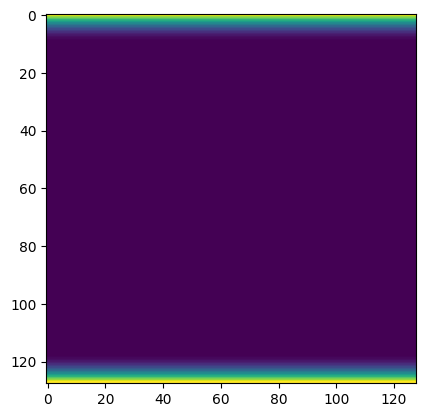

In [5]:
from jaxdf.operators import compose

# Coordinate field
x = Continuous(None, domain, lambda p, x: x)

plt.imshow(jnp.real(compose(x)(sigma).on_grid)[...,0])

In [6]:
from jax.nn.initializers import glorot_normal, normal

def First(out_dim, W_init=glorot_normal()):
    
    def init_fun(rng, input_shape):
        keys = random.split(rng, 4)
        projected_shape = input_shape[:-1] + (out_dim,)
        omega = W_init(keys[2], (input_shape[-1], out_dim))
        phi =  normal()(keys[3], (out_dim,))
        
        output_shape = (projected_shape, input_shape)
        
        return output_shape, (omega, phi)
    
    def apply_fun(params, z, **kwargs):
        omega, phi = params
        freq = jnp.dot(z, omega)
        y = jnp.sin(freq + phi)
        return (y, z)
    
    return init_fun, apply_fun

def Middle(W_init=glorot_normal()):
    
    def init_fun(rng, input_shape):
        y_shape, z_shape = input_shape
        
        keys = random.split(rng, 4)
        
        W = W_init(keys[0], (y_shape[-1], y_shape[-1]))
        b = normal()(keys[1], (y_shape[-1],))
        omega = W_init(keys[2], (z_shape[-1], y_shape[-1]))
        phi =  normal()(keys[3], (y_shape[-1],))
        
        return input_shape, (W, omega, b, phi)
    
    def apply_fun(params, inputs, **kwargs):
        W, omega, b, phi = params
        y, z = inputs
        y = jnp.dot(y, W)+ b
        g = jnp.sin(jnp.dot(z, omega)+ phi)
        return (y*g, z)
    return init_fun, apply_fun
        
def Final(out_dim, C_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        y_shape, _ = input_shape
        output_shape = y_shape[:-1] + (out_dim,)
        
        k1, k2 = random.split(rng)
        C = C_init(k1, (y_shape[-1], out_dim))
        b = b_init(k2, (out_dim,))
        
        return output_shape, (C,b)
    
    def apply_fun(params, inputs, **kwargs):
        y, z = inputs
        C, b = params
        return jnp.dot(y, C) + b
    return init_fun, apply_fun

init_random_params, predict = stax.serial(
    First(256),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Middle(),
    Final(2)
)

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    x = x
    p = predict(params, x)
    return jnp.asarray([p[0] + 1j*p[1]])

u = Continuous.from_function(domain, init_params, get_fun, seed)


In [7]:
from jaxdf.operators import *

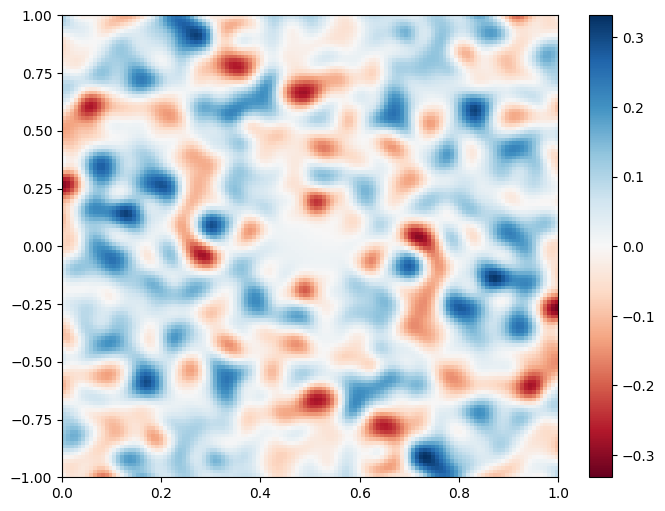

In [8]:
show_field(compose(u)(jnp.real))

In [9]:
coord = jnp.asarray([0. ,0.])
u(coord).shape

(1,)

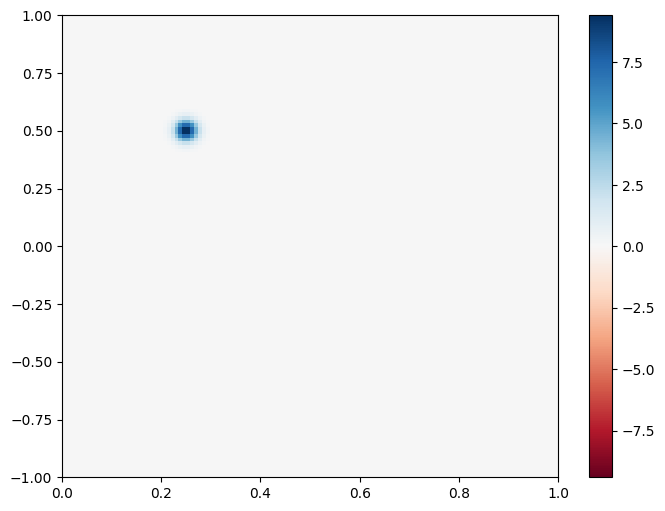

In [10]:
# Narrow gaussian pulse as source
def init_params(seed, domain):
    return {}

def gaussian_func(params, x):
    x = x + jnp.asarray([32,32])
    return jnp.expand_dims(jnp.exp(-jnp.sum(x**2)/8) + 0*1j, -1)*10

src = Continuous.from_function(domain, init_params, gaussian_func, seed)
show_field(compose(src)(jnp.abs))

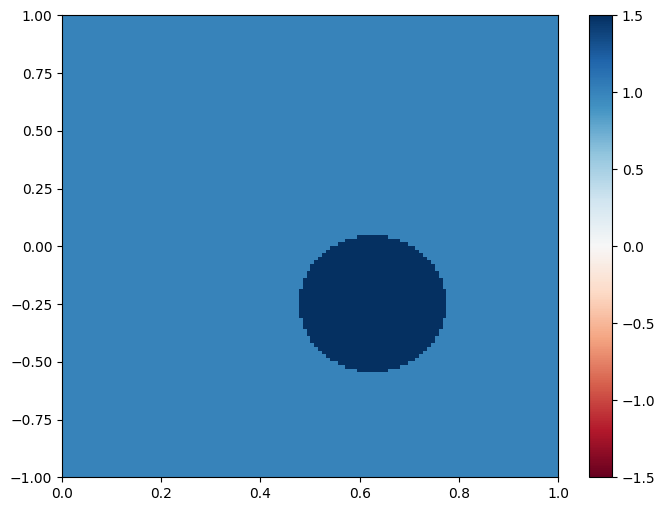

In [11]:
# Arbitrary Speed of Sound map
def init_params(seed, domain):
    return {}

def sos_func(params, x):
    x = x - jnp.asarray([16,16])
    x = jnp.exp(-jnp.sum(x**2)/512)
    x = jnp.where(jnp.abs(x)>0.5, .5, 0.)
    return jnp.expand_dims(x + 1., -1)
                  
c = Continuous.from_function(domain, init_params, sos_func, seed)
show_field(c)

In [18]:
from jax import value_and_grad

boundary_sampler = domain.boundary_sampler
domain_sampler = domain.domain_sampler

def boundary_loss(u, seed, batchsize):
    coords = boundary_sampler(seed, batchsize)
    field_val = jax.vmap(u)(coords)
    r = jnp.mean(jnp.abs(field_val)**2)
    return r

def domain_loss(u, seed, batchsize):    
    coords = domain_sampler(seed, batchsize)
    Hu = lambda coord: helmholtz(u, c, x)(coord)
    helm_val = jax.vmap(Hu)(coords)
    src_val = jax.vmap(src)(coords)
    r = jnp.mean(jnp.abs(src_val - helm_val)**2)
    return r

bound_valandgrad = value_and_grad(boundary_loss)
domain_valandgrad = value_and_grad(domain_loss)

In [22]:
def mod_laplacian(u, x):
    pml = gamma(x)
    grad_u = gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = diag_jacobian(mod_grad_u)*pml
    return sum_over_dims(mod_diag_jacobian)

def helmholtz(u, c, x, omega=omega):
    # Get the modified laplacian
    L = mod_laplacian(u, x)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u   
    return L + k

In [23]:
def show_field(u):
    u = u.on_grid
    maxval = jnp.amax(jnp.abs(u)) 
    plt.figure(figsize=(8,6))
    plt.imshow(u, cmap="RdBu", extent=[0,1,-1,1], vmin=-maxval/2, vmax=maxval/2, aspect='auto')
    plt.colorbar()
    plt.show()

In [24]:
# For logging 
import wandb

def log_image(wandb, field, name, step):
    maxval = jnp.amax(jnp.abs(field)) 
    plt.imshow(field[...,0].real, cmap='RdBu', vmin=-maxval/3, vmax=maxval/3)
    plt.colorbar()
    img = wandb.Image(plt)
    wandb.log({name: img}, step=step)
    plt.close()

In [26]:
# Training loop
from jax.example_libraries import optimizers
from jax import jit
from tqdm import tqdm
from jax import tree_map

losshistory = []
batch_size = 2**9

init_fun, update_fun, get_params = optimizers.adam(.00001)
opt_state = init_fun(u)

def loss(u, seed):
    seeds = random.split(seed, 2)
    return 0.01*boundary_loss(u, seeds[0], batch_size) +  domain_loss(u, seeds[1], batch_size)

@jit
def update(opt_state, seed, k):
    u = get_params(opt_state)
    seeds = random.split(seed, 2)
    
    # losses
    boundary_loss, b_gradient = bound_valandgrad(u, seeds[0], batch_size)
    domain_loss, d_gradient = domain_valandgrad(u, seeds[1], batch_size)
    
    # Add gradients of the parameters
    gradient_nn = tree_map(lambda x,y: 0.01*x+y, b_gradient, d_gradient)
    
    return boundary_loss, domain_loss, update_fun(k, gradient_nn, opt_state)

pbar = tqdm(range(1000000))
tol = 1e-3
rng = seed

wandb.init(project="helmholtz-pinn")

boundary_loss_h = 0.
domain_loss_h = 0.
for k in pbar:
    rng, seed = random.split(rng,2)
    #seed=rng
    boundary_loss, domain_loss, opt_state = update(opt_state, seed, k)
    losshistory.append(domain_loss)

    # For logging
    boundary_loss_h = boundary_loss_h + boundary_loss
    domain_loss_h = domain_loss_h + domain_loss
    if (k+1) % 500 == 0:
        boundary_loss_h = boundary_loss_h / 500.
        domain_loss_h = domain_loss_h / 500.
        wandb.log({'boundary_loss': boundary_loss_h, 'domain_loss': domain_loss_h}, step=k)
        pbar.set_description("B: {:01.4f} | D: {:01.4f}".format(
            jnp.log10(boundary_loss), 
            jnp.log10(domain_loss)
        ))
        boundary_loss_h = 0.
        domain_loss_h = 0.
        
        # Logging image
        V = get_params(opt_state).on_grid
        log_image(wandb, V, "wavefield", k)


  0%|                                                                                            | 0/1000000 [00:00<?, ?it/s]

  0%|                                                                               | 1/1000000 [00:13<3738:52:36, 13.46s/it]/home/astanziola/repos/jaxdf/.venv/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2088: UserWarning: Run (8bxjtlug) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
B: -3.4768 | D: -2.7340:  11%|█████▋                                             | 112415/1000000 [14:00<1:50:35, 133.77it/s]


KeyboardInterrupt: 

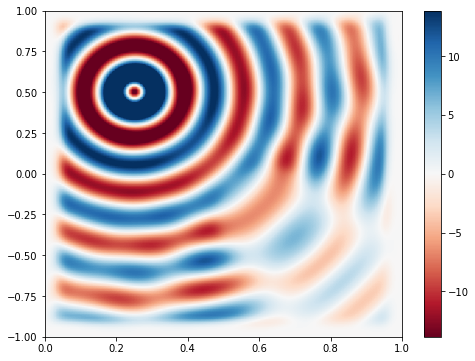

In [35]:
u = get_params(opt_state)

show_field(compose(u)(jnp.real))